- The french counties contours can be downloaded from https://melusine.eu.org/syracuse/jms/depfr/ . Download depfr-txt.zip (1.23 Mo – 6 juin 2010), put the unzipped files in homedir/FRENCH_STAT/depfr-txt 
- clone https://github.com/renewables-ninja/vw in your_homedir
- clone https://github.com/Bertin-fap/CIRED-ENS.git in your_homedir
- create your profile on https://www.renewables.ninja/profile obtain a token to emulate the ninja API
- install vre_eoles (pip install vre_eoles)
- the output files/directories will be stored in your_homedir/EOLES

In [7]:
# Standard library imports
from pathlib import Path
import os

year = 2015 # working year
mode = 'median'            #or "max"
wind_farm_type = 'onshore' # or "offshore"

EOLES = False # if EOLES=True we take the Shirizadeh et al (2022) article conditions (fix turbine and hub height)
              # if EOLES=False we take the turbine and hub height of the median powerfarm for each county )

new_turbine = True # we change the tubine model
                   # False we retain the turbine used when queriyng ninja
    
new_turbine_model = 'Vestas.V110.2000'

# Input an output files assignement
root_inputs_vwf = Path.home()/Path('vwf/power_curves') #vwf power curve 
root_inputs_eoles = Path.home()/Path('EOLES_elecRES/inputs') #EOLES vre profiles
root_inputs_wp = Path.home()/Path('FRENCH_STAT/WindPower') #WindPower directory

root_outputs_root = Path.home()/Path('EOLES')
if not os.path.exists(root_outputs_root):
    os.mkdir(root_outputs_root)

root_outputs = root_outputs_root / Path(str(year))
if not os.path.exists(root_outputs):
    os.mkdir(root_outputs)

if wind_farm_type == 'onshore':
    if EOLES:
        root_outputs = root_outputs / Path('EOLES')
        if not os.path.exists(root_outputs):
            os.mkdir(root_outputs)
    
    else:
        root_outputs = root_outputs / Path(mode)
        if not os.path.exists(root_outputs):
            os.mkdir(root_outputs)
else:
    root_outputs = root_outputs / Path('offshore')
    if not os.path.exists(root_outputs):
        os.mkdir(root_outputs)
    
root_vwf = Path.home() / Path('FRENCH_STAT/WindPower/Windfarms_France_20201220.xls') # list of windfarm from WINDPOWER
root_county = Path.home() / Path('FRENCH_STAT/depfr-txt') # French counties contours

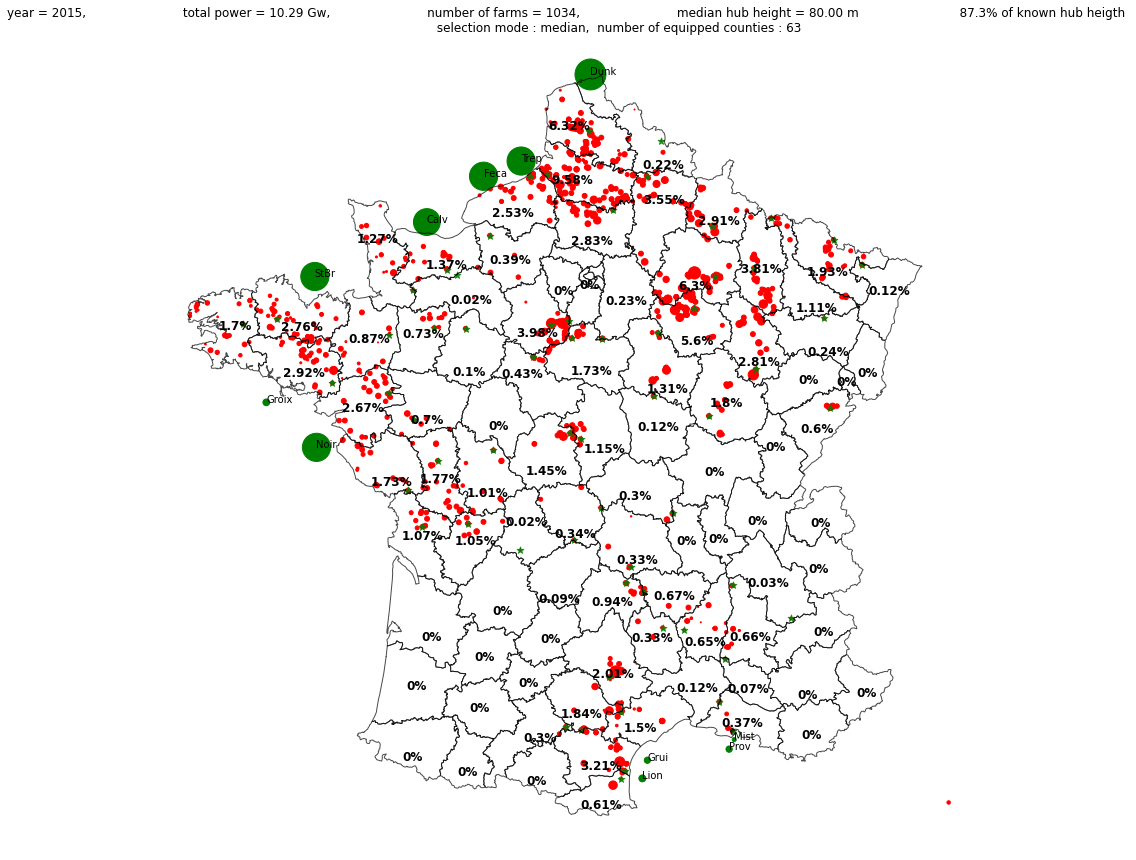

In [8]:
import vre_eoles as vre

df, median_hub_height, df_offshore = vre.french_wind_turbine_analysis(year, 
                                                                      root_vwf, 
                                                                      root_county, 
                                                                      mode=mode, 
                                                                      EOLES=EOLES)

# Building of VRE profiles for french wind farm


In [ ]:
'''
download nija files by an automatized access via the ninja API.
your must provide 
    - the year (int) 
    - a dataframe df Latitude|Longitude|Total power|Manufacturer|Model|Hub height
'''
from pathlib import Path
# povide your token
root_token = Path.home()/Path('CIRED-ENS/token.txt') 
with open(root_token, encoding='utf-8') as f:
    token = f.read() 

if wind_farm_type == 'offshore':
    vre.vwf_api(df_offshore, year, root_outputs, token, median_hub_height=median_hub_height)
else:
    vre.vwf_api(df, year, root_outputs, token, median_hub_height=median_hub_height,EOLES=EOLES)

# vre computation

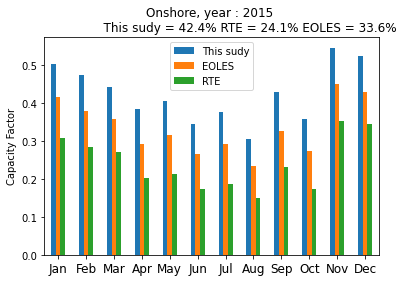

In [9]:
if new_turbine:
    Power_cuve00, Power_cuve01, Power_cuve02, Power_cuve03, Power_cuve04 = vre.read_vwf_power_curves(root_inputs_vwf)
    df_turbine = Power_cuve02[new_turbine_model]
else:
    df_turbine = None
    
vre_new, wind, df_metadata = vre.vre_aggregation(year,root_outputs,root_inputs_wp, new_turbine=df_turbine)

if wind_farm_type == 'offshore':
    VRE = vre.vre_computation(year, vre_new, df_offshore, root_inputs_eoles, wind_farm_type = wind_farm_type)
else:
    VRE = vre.vre_computation(year, vre_new, df, root_inputs_eoles, wind_farm_type = wind_farm_type)

# PCA analysis

In [ ]:
F = vre.wind_pca(wind.values)
if wind_farm_type == 'offshore': 
    vre.plot_wind_pca(F,df_offshore,wind,year)
else:
    vre.plot_wind_pca(F,df,wind,year)